In [1]:
import os
import sys
import time
import logging
import importlib
import numpy as np
import pandas as pd
import collections
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc,precision_recall_fscore_support, average_precision_score, precision_recall_curve, auc, confusion_matrix,accuracy_score

from tensorflow.keras import initializers, regularizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, LSTM, BatchNormalization, LeakyReLU, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise, MaxPooling2D, concatenate

from tensorflow.keras import backend as K

from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.metrics import *

import pickle
import gc

import random

random.seed(123)

In [2]:
import os
import pandas as pd
path=r"/kaggle/input/2022q4/data_Q4_2022"
files=os.listdir(path)
print(files)

['2022-11-05.csv', '2022-12-03.csv', '2022-10-10.csv', '2022-12-23.csv', '2022-11-02.csv', '2022-12-13.csv', '2022-12-20.csv', '2022-10-01.csv', '2022-11-11.csv', '2022-12-21.csv', '2022-12-29.csv', '2022-12-24.csv', '2022-10-25.csv', '2022-12-19.csv', '2022-11-09.csv', '2022-12-15.csv', '2022-10-07.csv', '2022-10-13.csv', '2022-12-28.csv', '2022-11-20.csv', '2022-10-28.csv', '2022-12-27.csv', '2022-10-18.csv', '2022-11-21.csv', '2022-12-26.csv', '2022-12-04.csv', '2022-12-25.csv', '2022-11-08.csv', '2022-12-05.csv', '2022-10-24.csv', '2022-10-04.csv', '2022-10-27.csv', '2022-10-30.csv', '2022-12-12.csv', '2022-12-10.csv', '2022-11-25.csv', '2022-11-24.csv', '2022-10-26.csv', '2022-10-19.csv', '2022-11-17.csv', '2022-10-05.csv', '2022-10-08.csv', '2022-12-08.csv', '2022-12-17.csv', '2022-12-02.csv', '2022-10-12.csv', '2022-12-31.csv', '2022-10-22.csv', '2022-10-06.csv', '2022-11-23.csv', '2022-12-22.csv', '2022-12-01.csv', '2022-10-11.csv', '2022-12-07.csv', '2022-11-13.csv', '2022-11-

In [3]:
df=pd.DataFrame()
for csv_file_name in files:
  df2=pd.read_csv(path+'/'+csv_file_name)
  df2=df2.loc[df2['model']=='ST4000DM000']
  df2=df2[df2.columns.drop(list(df2.filter(regex='normalized')))]
  df2.dropna(how='all',axis=1,inplace=True)
  df=df.append(df2,ignore_index=True)
  first_one=False
df

,date,serial_number,model,capacity_bytes,failure,smart_1_raw,smart_3_raw,smart_4_raw,smart_5_raw,smart_7_raw,...,smart_191_raw,smart_192_raw,smart_193_raw,smart_194_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
0,2022-11-05,Z301YSCQ,ST4000DM000,4000787030016,0,241169656.0,0.0,9.0,0.0,181699603.0,...,0.0,1.0,8760.0,19.0,0.0,0.0,0.0,65373.0,6.859221e+10,6.594531e+11
1,2022-11-05,W301AMK6,ST4000DM000,4000787030016,0,219537264.0,0.0,4.0,0.0,279836092.0,...,0.0,0.0,816.0,18.0,0.0,0.0,0.0,46580.0,3.715501e+10,3.305102e+11
2,2022-11-05,Z3074TTN,ST4000DM000,4000787030016,0,214631488.0,0.0,4.0,0.0,55346185.0,...,0.0,0.0,75.0,18.0,0.0,0.0,0.0,41855.0,3.474564e+10,2.795555e+11
3,2022-11-05,W300R7HN,ST4000DM000,4000787030016,0,25376080.0,0.0,24.0,0.0,892001844.0,...,0.0,3.0,9903.0,18.0,0.0,0.0,0.0,65530.0,6.357842e+10,3.352081e+11
4,2022-11-05,W300R7PJ,ST4000DM000,4000787030016,0,160479128.0,0.0,26.0,0.0,921247658.0,...,0.0,4.0,9795.0,20.0,0.0,0.0,0.0,65538.0,6.186544e+10,3.565477e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1682384,2022-11-18,Z304NT6A,ST4000DM000,4000787030016,0,166302792.0,0.0,9.0,0.0,440612082.0,...,0.0,0.0,3450.0,26.0,248.0,248.0,0.0,41900.0,3.620208e+10,1.032172e+12
1682385,2022-11-18,Z306YWWD,ST4000DM000,4000787030016,0,32029472.0,0.0,4.0,0.0,496119904.0,...,0.0,0.0,1897.0,28.0,0.0,0.0,0.0,15949.0,1.687077e+10,2.200156e+12
1682386,2022-11-18,Z304A3PD,ST4000DM000,4000787030016,0,240495416.0,0.0,4.0,0.0,552170511.0,...,0.0,1.0,4.0,22.0,0.0,0.0,0.0,16194.0,1.738352e+10,1.265126e+12
1682387,2022-11-18,Z305TJ83,ST4000DM000,4000787030016,0,84450704.0,0.0,10.0,0.0,835557594.0,...,0.0,0.0,3904.0,27.0,0.0,0.0,0.0,26662.0,2.240205e+10,1.546230e+12


In [4]:
df.sort_values(by=['serial_number','date'],ascending=[True,True],inplace=True)
print(df.head())

               date serial_number        model  capacity_bytes  failure  \
134166   2022-10-01      S3001HBH  ST4000DM000   4000787030016        0   
1286156  2022-10-02      S3001HBH  ST4000DM000   4000787030016        0   
1432511  2022-10-03      S3001HBH  ST4000DM000   4000787030016        0   
554595   2022-10-04      S3001HBH  ST4000DM000   4000787030016        0   
737524   2022-10-05      S3001HBH  ST4000DM000   4000787030016        0   

         smart_1_raw  smart_3_raw  smart_4_raw  smart_5_raw  smart_7_raw  ...  \
134166    96957360.0          0.0         31.0          0.0   38999062.0  ...   
1286156   62367064.0          0.0         31.0          0.0   40071257.0  ...   
1432511  136702336.0          0.0         31.0          0.0   41117487.0  ...   
554595   143082680.0          0.0         31.0          0.0   42093333.0  ...   
737524   134823584.0          0.0         31.0          0.0   44942992.0  ...   

         smart_191_raw  smart_192_raw  smart_193_raw  smart_19

In [5]:
df.ffill(axis=0,inplace=True)
df.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_raw,smart_3_raw,smart_4_raw,smart_5_raw,smart_7_raw,...,smart_191_raw,smart_192_raw,smart_193_raw,smart_194_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
134166,2022-10-01,S3001HBH,ST4000DM000,4000787030016,0,96957360.0,0.0,31.0,0.0,38999062.0,...,0.0,3.0,11581.0,27.0,0.0,0.0,0.0,61496.0,7.143272e+10,4.296386e+11
1286156,2022-10-02,S3001HBH,ST4000DM000,4000787030016,0,62367064.0,0.0,31.0,0.0,40071257.0,...,0.0,3.0,11581.0,27.0,0.0,0.0,0.0,61519.0,7.143504e+10,4.298920e+11
1432511,2022-10-03,S3001HBH,ST4000DM000,4000787030016,0,136702336.0,0.0,31.0,0.0,41117487.0,...,0.0,3.0,11581.0,26.0,0.0,0.0,0.0,61543.0,7.143662e+10,4.301418e+11
554595,2022-10-04,S3001HBH,ST4000DM000,4000787030016,0,143082680.0,0.0,31.0,0.0,42093333.0,...,0.0,3.0,11581.0,26.0,0.0,0.0,0.0,61567.0,7.143811e+10,4.304117e+11
737524,2022-10-05,S3001HBH,ST4000DM000,4000787030016,0,134823584.0,0.0,31.0,0.0,44942992.0,...,0.0,3.0,11581.0,27.0,0.0,0.0,0.0,61590.0,7.143950e+10,4.308534e+11


In [6]:
import numpy as np
df['normal_disk_subsequence']=np.where(df['failure']!=0,1,0)
print(df.head())

               date serial_number        model  capacity_bytes  failure  \
134166   2022-10-01      S3001HBH  ST4000DM000   4000787030016        0   
1286156  2022-10-02      S3001HBH  ST4000DM000   4000787030016        0   
1432511  2022-10-03      S3001HBH  ST4000DM000   4000787030016        0   
554595   2022-10-04      S3001HBH  ST4000DM000   4000787030016        0   
737524   2022-10-05      S3001HBH  ST4000DM000   4000787030016        0   

         smart_1_raw  smart_3_raw  smart_4_raw  smart_5_raw  smart_7_raw  ...  \
134166    96957360.0          0.0         31.0          0.0   38999062.0  ...   
1286156   62367064.0          0.0         31.0          0.0   40071257.0  ...   
1432511  136702336.0          0.0         31.0          0.0   41117487.0  ...   
554595   143082680.0          0.0         31.0          0.0   42093333.0  ...   
737524   134823584.0          0.0         31.0          0.0   44942992.0  ...   

         smart_192_raw  smart_193_raw  smart_194_raw  smart_19

In [7]:
df['sequence_number']=df.reset_index(inplace=False).index+1
print(df.tail())

               date serial_number        model  capacity_bytes  failure  \
393536   2022-12-27      Z307X70A  ST4000DM000   4000787030016        0   
338701   2022-12-28      Z307X70A  ST4000DM000   4000787030016        0   
192468   2022-12-29      Z307X70A  ST4000DM000   4000787030016        0   
1143327  2022-12-30      Z307X70A  ST4000DM000   4000787030016        0   
850720   2022-12-31      Z307X70A  ST4000DM000   4000787030016        0   

         smart_1_raw  smart_3_raw  smart_4_raw  smart_5_raw  smart_7_raw  ...  \
393536   211209200.0          0.0          9.0          0.0  249139711.0  ...   
338701   228000608.0          0.0          9.0          0.0  251037345.0  ...   
192468    19773496.0          0.0          9.0          0.0  252270533.0  ...   
1143327   52243144.0          0.0          9.0          0.0  253496444.0  ...   
850720    43071576.0          0.0          9.0          0.0  256179216.0  ...   

         smart_193_raw  smart_194_raw  smart_197_raw  smart_19

In [8]:
df=pd.concat([df['sequence_number'],df.drop('sequence_number',axis=1)],axis=1)
df=pd.concat([df['normal_disk_subsequence'],df.drop('normal_disk_subsequence',axis=1)],axis=1)
df

,normal_disk_subsequence,sequence_number,date,serial_number,model,capacity_bytes,failure,smart_1_raw,smart_3_raw,smart_4_raw,...,smart_191_raw,smart_192_raw,smart_193_raw,smart_194_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
134166,0,1,2022-10-01,S3001HBH,ST4000DM000,4000787030016,0,96957360.0,0.0,31.0,...,0.0,3.0,11581.0,27.0,0.0,0.0,0.0,61496.0,7.143272e+10,4.296386e+11
1286156,0,2,2022-10-02,S3001HBH,ST4000DM000,4000787030016,0,62367064.0,0.0,31.0,...,0.0,3.0,11581.0,27.0,0.0,0.0,0.0,61519.0,7.143504e+10,4.298920e+11
1432511,0,3,2022-10-03,S3001HBH,ST4000DM000,4000787030016,0,136702336.0,0.0,31.0,...,0.0,3.0,11581.0,26.0,0.0,0.0,0.0,61543.0,7.143662e+10,4.301418e+11
554595,0,4,2022-10-04,S3001HBH,ST4000DM000,4000787030016,0,143082680.0,0.0,31.0,...,0.0,3.0,11581.0,26.0,0.0,0.0,0.0,61567.0,7.143811e+10,4.304117e+11
737524,0,5,2022-10-05,S3001HBH,ST4000DM000,4000787030016,0,134823584.0,0.0,31.0,...,0.0,3.0,11581.0,27.0,0.0,0.0,0.0,61590.0,7.143950e+10,4.308534e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393536,0,1682385,2022-12-27,Z307X70A,ST4000DM000,4000787030016,0,211209200.0,0.0,9.0,...,0.0,0.0,1160.0,22.0,0.0,0.0,0.0,49443.0,3.983256e+10,3.738506e+11
338701,0,1682386,2022-12-28,Z307X70A,ST4000DM000,4000787030016,0,228000608.0,0.0,9.0,...,0.0,0.0,1160.0,22.0,0.0,0.0,0.0,49467.0,3.983366e+10,3.741165e+11
192468,0,1682387,2022-12-29,Z307X70A,ST4000DM000,4000787030016,0,19773496.0,0.0,9.0,...,0.0,0.0,1160.0,22.0,0.0,0.0,0.0,49491.0,3.983468e+10,3.743113e+11
1143327,0,1682388,2022-12-30,Z307X70A,ST4000DM000,4000787030016,0,52243144.0,0.0,9.0,...,0.0,0.0,1160.0,22.0,0.0,0.0,0.0,49515.0,3.983588e+10,3.744655e+11


In [9]:
from sklearn import preprocessing
df3=df.iloc[:,5:]
names=df3.columns
scaler=preprocessing.MinMaxScaler()
d=scaler.fit_transform(df3)
df2=pd.DataFrame(d,columns=names)
df2["sequence_number"]=df["sequence_number"]
df2["normal_disk_subsequence"]=df["normal_disk_subsequence"]
df2["date"]=df["date"]
df2["serial_number"]=df["serial_number"]
df2["model"]=df["model"]
df2=pd.concat([df2['model'],df2.drop('model',axis=1)],axis=1)
df2=pd.concat([df2['serial_number'],df2.drop('serial_number',axis=1)],axis=1)
df2=pd.concat([df2['date'],df2.drop('date',axis=1)],axis=1)
df2=pd.concat([df['normal_disk_subsequence'],df2.drop('normal_disk_subsequence',axis=1)],axis=1)
df2=pd.concat([df['sequence_number'],df2.drop('sequence_number',axis=1)],axis=1)
df2.sort_values(by=['serial_number','date'],ascending=[True,True],inplace=True)
df2

,sequence_number,normal_disk_subsequence,date,serial_number,model,capacity_bytes,failure,smart_1_raw,smart_3_raw,smart_4_raw,...,smart_191_raw,smart_192_raw,smart_193_raw,smart_194_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
134166,1,0,2022-10-01,S3001HBH,ST4000DM000,1.0,0.0,0.469937,0.0,0.000565,...,0.0,0.000100,0.012406,0.275862,0.00000,0.00000,0.0,0.859136,0.792201,0.080275
1286156,2,0,2022-10-02,S3001HBH,ST4000DM000,1.0,0.0,0.662157,0.0,0.000266,...,0.0,0.000000,0.021363,0.189655,0.00000,0.00000,0.0,0.827275,0.706950,0.086618
1432511,3,0,2022-10-03,S3001HBH,ST4000DM000,1.0,0.0,0.391044,0.0,0.000332,...,0.0,0.000000,0.003462,0.120690,0.00000,0.00000,0.0,0.815636,0.711278,0.077691
554595,4,0,2022-10-04,S3001HBH,ST4000DM000,1.0,0.0,0.242994,0.0,0.000532,...,0.0,0.000033,0.034650,0.068966,0.00000,0.00000,0.0,0.947497,0.847257,0.082621
737524,5,0,2022-10-05,S3001HBH,ST4000DM000,1.0,0.0,0.491251,0.0,0.000864,...,0.0,0.000167,0.084531,0.137931,0.00000,0.00000,0.0,0.828986,0.572927,0.113337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393536,1682385,0,2022-12-27,Z307X70A,ST4000DM000,1.0,0.0,0.047780,0.0,0.000632,...,0.0,0.000100,0.006018,0.224138,0.00000,0.00000,0.0,0.836124,0.775215,0.080717
338701,1682386,0,2022-12-28,Z307X70A,ST4000DM000,1.0,0.0,0.084258,0.0,0.000465,...,0.0,0.000000,0.022512,0.051724,0.00072,0.00072,0.0,0.920516,0.828080,0.078400
192468,1682387,0,2022-12-29,Z307X70A,ST4000DM000,1.0,0.0,0.834395,0.0,0.000133,...,0.0,0.000000,0.026685,0.120690,0.00000,0.00000,0.0,0.904894,0.795401,0.082542
1143327,1682388,0,2022-12-30,Z307X70A,ST4000DM000,1.0,0.0,0.987519,0.0,0.000133,...,0.0,0.000000,0.005002,0.396552,0.00000,0.00000,0.0,0.827359,0.710309,0.075090


In [10]:
def split_series2(series,n_past,n_future):
  X,Y=list(),list()
  for start in range(len(series)):
    past_end=start+n_past
    future_end=past_end+n_future
    if future_end>len(series):
      break
    future=series[past_end:future_end, 6:7]
    if(future==0):
      past,future=series[start:past_end, 7:],series[past_end:future_end, 6:7]
      X.append(past)
      Y.append(future)
  return np.array(X),np.array(Y)

In [11]:
n_past=16
n_future=1
n_features=24

In [12]:
train=df2

In [13]:
X_train2,Y_train2=split_series2(train.values,n_past,n_future)
X_train2=X_train2.reshape((X_train2.shape[0],X_train2.shape[1],n_features))
Y_train2=Y_train2.reshape((Y_train2.shape[0],Y_train2.shape[1],1))

In [14]:
X_train2.shape

(1682215, 16, 24)

In [15]:
x_train1=X_train2[0:500]
x_train2=X_train2[50000:50500]
x_train3=X_train2[175000:175500]
x_train4=X_train2[200000:200500]
x_train5=X_train2[1000000:1001000]
x_train6=X_train2[1500000:1501500]

In [16]:
x_train=np.concatenate((x_train1,x_train2,x_train3,x_train4,x_train5,x_train6))

In [17]:
x_train.shape

(4500, 16, 24)

In [18]:
data_shape = x_train.shape[1:]   
    
## Some parameters to change
dp_lvl = 0.2
lstm_width = 128

inputs = Input(shape=(data_shape))
encoded = LSTM(lstm_width, dropout = dp_lvl, recurrent_dropout = dp_lvl, return_sequences =  False, activation='relu')(inputs)
decoded = RepeatVector(data_shape[0])(encoded)
decoded = LSTM(lstm_width, return_sequences=True, activation='relu')(decoded)
decoded = LSTM(data_shape[1], activation='tanh', return_sequences=True)(decoded)

# Build entire model
autoencoder = Model(inputs, decoded)

# Parameters to control learning rate
learning_rate = 0.001

optimizer = Adam(lr=learning_rate)
autoencoder.compile(optimizer=optimizer, loss='mae')
    
print(autoencoder.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 24)]          0         
                                                                 
 lstm (LSTM)                 (None, 128)               78336     
                                                                 
 repeat_vector (RepeatVector  (None, 16, 128)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 16, 128)           131584    
                                                                 
 lstm_2 (LSTM)               (None, 16, 24)            14688     
                                                                 
Total params: 224,608
Trainable params: 224,608
Non-trainable params: 0
_______________________________________________________

In [19]:
data_dir = "./data/"

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# checkpoint
checkpoint = ModelCheckpoint(data_dir+"best_model_ae-lstm.h5", monitor='val_loss', 
                             verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(patience=20, verbose=1)

callbacks_list = [es, checkpoint]

In [21]:
x_train=np.asarray(x_train).astype(np.float32)

In [22]:
epochs_num = 60
history = autoencoder.fit(x_train, x_train, batch_size=128, epochs=epochs_num, validation_split=0.1, verbose=1, callbacks=callbacks_list) 

Epoch 1/60
32/32 [==============================] - ETA: 0s - loss: 0.0972
Epoch 1: val_loss improved from inf to 0.04473, saving model to ./data/best_model_ae-lstm.h5
32/32 [==============================] - 10s 136ms/step - loss: 0.0972 - val_loss: 0.0447
Epoch 2/60
32/32 [==============================] - ETA: 0s - loss: 0.0351
Epoch 2: val_loss improved from 0.04473 to 0.02859, saving model to ./data/best_model_ae-lstm.h5
32/32 [==============================] - 3s 105ms/step - loss: 0.0351 - val_loss: 0.0286
Epoch 3/60
32/32 [==============================] - ETA: 0s - loss: 0.0260
Epoch 3: val_loss improved from 0.02859 to 0.02543, saving model to ./data/best_model_ae-lstm.h5
32/32 [==============================] - 3s 107ms/step - loss: 0.0260 - val_loss: 0.0254
Epoch 4/60
32/32 [==============================] - ETA: 0s - loss: 0.0245
Epoch 4: val_loss improved from 0.02543 to 0.02484, saving model to ./data/best_model_ae-lstm.h5
32/32 [==============================] - 3s 105m

In [23]:
# load weights from best model
print(data_dir+"best_model_ae-lstm.h5")
autoencoder.load_weights(data_dir+"best_model_ae-lstm.h5")

./data/best_model_ae-lstm.h5


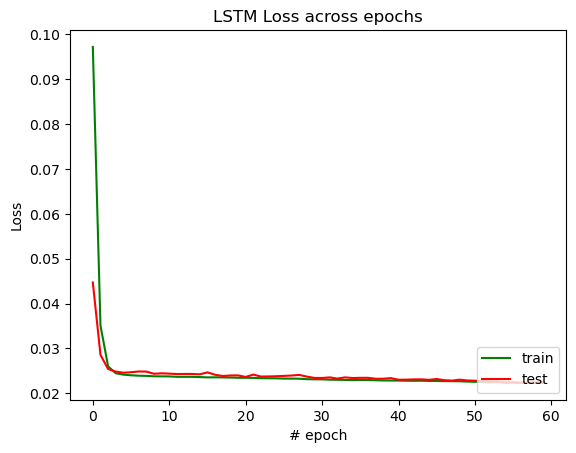

In [24]:
# show plot accuracy changes during training

plt.plot(history.history['loss'],'g')
plt.plot(history.history['val_loss'],'r')
plt.title('LSTM Loss across epochs')
plt.ylabel('Loss')
plt.xlabel('# epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [25]:
def split_series(series,n_past,n_future):
  X,Y=list(),list()
  for start in range(len(series)):
    past_end=start+n_past
    future_end=past_end+n_future
    if future_end>len(series):
      break
    future=series[past_end:future_end,6:7]
    if(future==1):
      past,future=series[start:past_end, 7:],series[past_end:future_end, 6:7]
      X.append(past)
      Y.append(future)
  return np.array(X),np.array(Y)

In [26]:
X_test,Y_test=split_series(train.values,n_past,n_future)

In [27]:
X_test.shape

(158, 16, 24)

In [28]:
Y_test.shape

(158, 1, 1)

In [29]:
X_test2=X_train2[500000:500300]
Y_test2=Y_train2[500000:500300]

In [30]:
X_test3=X_train2[700000:700300]
Y_test3=Y_train2[700000:700300]

In [31]:
X_test4=X_test[1:75]
Y_test4=Y_test[1:75]
X_test5=X_test[75:]
Y_test5=Y_test[75:]

In [32]:
x_test=np.concatenate((X_test2,X_test4,X_test3,X_test5))

In [33]:
y_test=np.concatenate((Y_test2,Y_test4,Y_test3,Y_test5))

In [34]:
y_test.shape

(757, 1, 1)

In [35]:
x_test=np.asarray(x_test).astype(np.float32)
y_test=np.asarray(y_test).astype(np.float32)

In [36]:
# Use model to predict on test data set
y_pred = autoencoder.predict(x_test)

24/24 [==============================] - 1s 15ms/step


This record is from a normal disk.


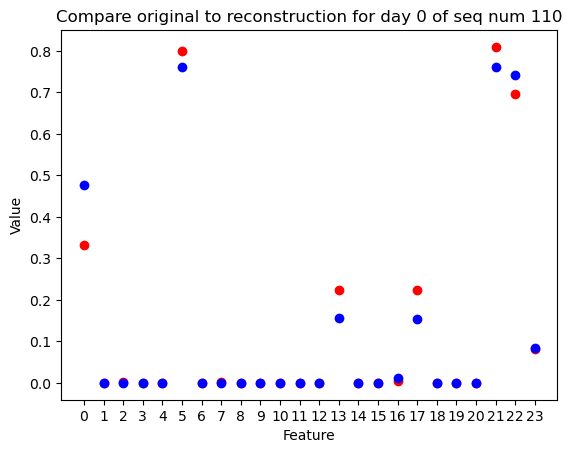

In [37]:
# create horizontal positions for scatter plot
x_pos = np.arange(x_test.shape[2])

# select random record
rec_num = random.randint(0, y_pred.shape[0])

# plot predicted points
plt.scatter(x_pos, x_test[rec_num,0,:], c="#ff0000")
plt.scatter(x_pos, y_pred[rec_num,0,:], c="#0000ff")

# label graph
plt.xlabel("Feature")
plt.ylabel("Value")
plt.xticks(range(x_test.shape[2]))
plt.title("Compare original to reconstruction for day 0 of seq num " + str(rec_num))

if y_test[rec_num] == 0:
    print("This record is from a normal disk.")
else:
    print("This record is from an anomalous disk.")

In [38]:
# Calcuate MSE for all sequences and predictions
import statistics

# determine median mse to split data into normal vs anomaly
pred_mse = []  # calculated mse for test data
pred_res = []  # result: 0 normal, 1 anomaly

for i in range(len(x_test)):
    pred_mse.append(mean_squared_error(y_pred[i,:,:], x_test[i,:,:]))

# Find number of disks that we know are normal and use that value as splitting point for data
num_normal_disks = list(y_test).count(0)

sort_mse = pred_mse.copy()
sort_mse.sort()
suggested_threshold = sort_mse[num_normal_disks]
print("Suggested Threshold:", suggested_threshold)

Suggested Threshold: 0.0049751676


In [39]:
# Routine to specify whether or not a sequence is anomalous

# specify override threshold or leave 0 to use suggested threshold
override_threshold = 0

if override_threshold == 0:
    threshold = suggested_threshold
else:
    threshold = override_threshold

for mse in pred_mse:
    if (mse <= threshold):
        pred_res.append(0)
    else:
        pred_res.append(1)
        
print("Used threshold:", threshold)
print("Resulting in the following classification of predicted data:")
print("- Normal Disks:   ", pred_res.count(0))
print("- Anomalous Disks:", pred_res.count(1))

Used threshold: 0.0049751676
Resulting in the following classification of predicted data:
- Normal Disks:    601
- Anomalous Disks: 156


In [40]:
# Routine to specify whether or not a sequence is anomalous

# specify override threshold or leave 0 to use suggested threshold
override_threshold = 0

if override_threshold == 0:
    threshold = suggested_threshold
else:
    threshold = override_threshold

for mse in pred_mse:
    if (mse <= threshold):
        pred_res.append(0)
    else:
        pred_res.append(1)
        
print("Used threshold:", threshold)
print("Resulting in the following classification of predicted data:")
print("- Normal Disks:   ", pred_res.count(0))
print("- Anomalous Disks:", pred_res.count(1))

Used threshold: 0.0049751676
Resulting in the following classification of predicted data:
- Normal Disks:    1202
- Anomalous Disks: 312
